## How TomTom represents traffic (brief)

TomTom aggregates probe data (floating car / GPS reports from connected vehicles and apps) and station/sensor data to estimate traffic on road segments. The typical fields you will see in their `flowSegmentData` style responses and our CSV/JSON exports are:
- `currentSpeed`: estimated current speed on the sampled point/segment (km/h).
- `freeFlowSpeed`: the typical uncongested speed for the segment (km/h).
- `travelTime`: estimated travel time for the segment (seconds).
- `confidence` / `level`: a reliability indicator for the estimate.
- `length` / `segmentLength`: segment length used to compute travel time / speed.

TomTom computes traffic by comparing observed speeds to free-flow speeds, applying smoothing, filtering outliers, and using model-based fusion across probes and infrastructure to produce segment-level estimates and confidence scores. For prediction we typically use `currentSpeed` (or `travelTime`) as the target, and time-of-day, day-of-week, weather or nearby segment speeds as features.

In [55]:
# Imports and settings
import json
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 200

In [56]:
# Helper: load historical JSON dumps from data/tomtom/<region>/
import re

def load_tomtom_jsons(region: str, data_root: Path = Path('..') / 'data' / 'tomtom') -> pd.DataFrame:
    folder = data_root / region
    if not folder.exists():
        raise FileNotFoundError(f'Folder not found: {folder}')
    files = sorted(glob.glob(str(folder / '*.json')))
    if not files:
        raise FileNotFoundError(f'No JSON files found in {folder}')

    rows = []
    for fp in files:
        try:
            j = json.load(open(fp, 'r', encoding='utf-8'))
        except Exception:
            # skip broken files
            continue

        # attempt to parse timestamp from filename, e.g. eindhoven_20251207T205959Z.json
        file_ts = None
        try:
            stem = Path(fp).stem
            m = re.search(r'(\d{8}T\d{6}Z)', stem)
            if m:
                file_ts = pd.to_datetime(m.group(1), format='%Y%m%dT%H%M%SZ', utc=True, errors='coerce')
        except Exception:
            file_ts = None

        # expect a list of records or a top-level object with 'records'/'items'
        if isinstance(j, dict):
            candidates = None
            for k in ('records', 'items', 'features', 'results'):
                if k in j and isinstance(j[k], list):
                    candidates = j[k]
                    break
            if candidates is None:
                candidates = [j]
        elif isinstance(j, list):
            candidates = j
        else:
            continue

        # Heuristic: skip files that contain mostly API error messages and no useful traffic fields
        try:
            n = len(candidates)
            n_error = 0
            n_useful = 0
            for rec in candidates:
                if isinstance(rec, dict):
                    if any(k in rec for k in ('currentSpeed', 'speed', 'travelTime', 'freeFlowSpeed', 'confidence', 'level')):
                        n_useful += 1
                    # look for common error indicators in values
                    if 'error' in rec:
                        n_error += 1
                    else:
                        for v in rec.values():
                            try:
                                vs = str(v).lower()
                                if 'forbidden' in vs or 'client error' in vs or '403' in vs or 'error' in vs or 'http' in vs:
                                    n_error += 1
                                    break
                            except Exception:
                                continue
                else:
                    s = str(rec).lower()
                    if 'forbidden' in s or 'client error' in s or '403' in s or 'error' in s or 'http' in s:
                        n_error += 1
            if n_useful == 0 and n > 0 and (n_error / n) > 0.4:
                continue
        except Exception:
            pass

        for rec in candidates:
            if isinstance(rec, dict):
                rec_copy = dict(rec)
                rec_copy['__file'] = fp
                rec_copy['__file_ts'] = file_ts
                rows.append(rec_copy)
            else:
                rows.append({'value': rec, '__file': fp, '__file_ts': file_ts})

    if not rows:
        return pd.DataFrame()

    df = pd.json_normalize(rows)

    # Prefer explicit time-like columns; convert to datetime safely
    # Note: avoid interpreting numeric duration fields (e.g., 'travelTime') as timestamps
    time_cols = [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower() or c.lower().endswith('timestamp')]
    ts_col = None
    for c in time_cols:
        try:
            s = pd.to_datetime(df[c], utc=True, errors='coerce')
            # guard: accept this column only if a reasonable number of parsed values
            # fall into a plausible year range (e.g., 2000-2100). This prevents fields
            # like 'travelTime' (small integers) becoming 1970-01-01 when coerced.
            if s.notna().any():
                try:
                    good = s.dt.year.between(2000, 2100).sum()
                except Exception:
                    good = 0
                threshold = max(1, int(0.01 * len(s)))
                if good >= threshold:
                    ts_col = c
                    df[c] = s
                    df['_ts'] = df[c]
                    break
        except Exception:
            continue

    # If no explicit timestamp, but filename carried a timestamp, use that
    if ('_ts' not in df.columns or df['_ts'].isna().all()) and '__file_ts' in df.columns:
        try:
            df['_ts'] = pd.to_datetime(df['__file_ts'], utc=True, errors='coerce')
        except Exception:
            df['_ts'] = pd.NaT

    # Do NOT create epoch-based garbage. If still missing, set to NaT and let downstream handle it.
    if '_ts' not in df.columns:
        df['_ts'] = pd.NaT

    # coerce numeric fields
    for nm in ('currentSpeed','freeFlowSpeed','travelTime','speed'):
        if nm in df.columns:
            df[nm] = pd.to_numeric(df[nm], errors='coerce')

    return df


In [57]:
# Example: load historical data for a region
region = 'eindhoven'  # change to your region folder name (slugified)
hist = load_tomtom_jsons(region)
print('Loaded rows:', len(hist))
hist.columns[:80]

Loaded rows: 13962


Index(['lat', 'lon', 'currentSpeed', 'freeFlowSpeed', 'confidence',
       'currentTravelTime', 'freeFlowTravelTime', '__file', '__file_ts',
       'error', '_ts'],
      dtype='object')

In [58]:
# Feature engineering helper
def prepare_features(df: pd.DataFrame, timestamp_col_candidates=None) -> pd.DataFrame:
    df = df.copy()

    # If a valid _ts column already exists, ensure it's datetime
    if '_ts' in df.columns:
        try:
            df['_ts'] = pd.to_datetime(df['_ts'], utc=True, errors='coerce')
        except Exception:
            df['_ts'] = pd.NaT

    # If no _ts or all NaT, try other timestamp-like columns
    if df.get('_ts').isna().all():
        ts_cols = timestamp_col_candidates or [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower() or c.lower()=='timestamp']
        for c in ts_cols:
            if c in df.columns:
                try:
                    cand = pd.to_datetime(df[c], utc=True, errors='coerce')
                    # guard: ensure parsed datetimes look like real dates
                    if cand.notna().any():
                        try:
                            good = cand.dt.year.between(2000, 2100).sum()
                        except Exception:
                            good = 0
                        threshold = max(1, int(0.01 * len(cand)))
                        if good >= threshold:
                            df['_ts'] = cand
                            break
                except Exception:
                    continue

    # If still missing, try filename timestamp column '__file_ts'
    if df.get('_ts').isna().all() and '__file_ts' in df.columns:
        try:
            df['_ts'] = pd.to_datetime(df['__file_ts'], utc=True, errors='coerce')
        except Exception:
            df['_ts'] = pd.NaT

    # As last resort create a dummy increasing time index (2000-01-01) to avoid 1970 epoch
    if df.get('_ts').isna().all():
        df['_ts'] = pd.date_range('2000-01-01', periods=len(df), freq='T', tz='UTC')

    df['_hour'] = df['_ts'].dt.hour
    df['_dow'] = df['_ts'].dt.dayofweek
    # cyclic encoding for hour
    df['hour_sin'] = np.sin(2 * np.pi * df['_hour'] / 24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['_hour'] / 24.0)

    # spatial grouping: round lat/lon if available to group nearby samples
    lat_cols = [c for c in df.columns if c.lower().endswith('lat') or c.lower().startswith('lat')]
    lon_cols = [c for c in df.columns if c.lower().endswith('lon') or c.lower().startswith('lon')]
    if lat_cols and lon_cols:
        latc = lat_cols[0]; lonc = lon_cols[0]
        df['_plat'] = pd.to_numeric(df[latc], errors='coerce').round(5)
        df['_plon'] = pd.to_numeric(df[lonc], errors='coerce').round(5)
        df['_pkey'] = df['_plat'].astype(str) + '_' + df['_plon'].astype(str)
    else:
        df['_pkey'] = 'no_spatial'

    # target: prefer currentSpeed, fallback to speed or travelTime/length if available
    if 'currentSpeed' in df.columns:
        df['target_speed'] = pd.to_numeric(df['currentSpeed'], errors='coerce')
    elif 'speed' in df.columns:
        df['target_speed'] = pd.to_numeric(df['speed'], errors='coerce')
    elif 'travelTime' in df.columns and 'length' in df.columns:
        df['target_speed'] = pd.to_numeric(df['length'], errors='coerce') / pd.to_numeric(df['travelTime'], errors='coerce') * 3.6
    else:
        df['target_speed'] = np.nan

    # sort and create simple lag features per pkey
    df = df.sort_values('_ts')
    df['lag1'] = df.groupby('_pkey')['target_speed'].shift(1)
    df['lag2'] = df.groupby('_pkey')['target_speed'].shift(2)
    df['rolling_mean_3'] = df.groupby('_pkey')['target_speed'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)

    # drop rows without target
    df = df[~df['target_speed'].isna()]

    return df


After feature prep: 13961
Training rows: 8813 Test rows: 5148
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 2204, number of used features: 6
[LightGBM] [Info] Start training from score 56.465971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train

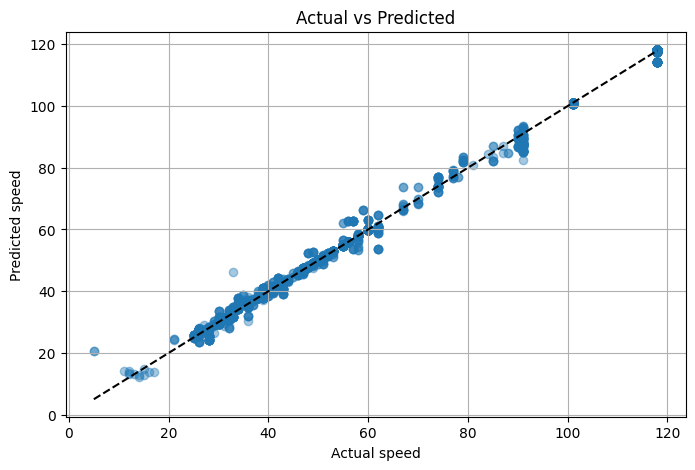

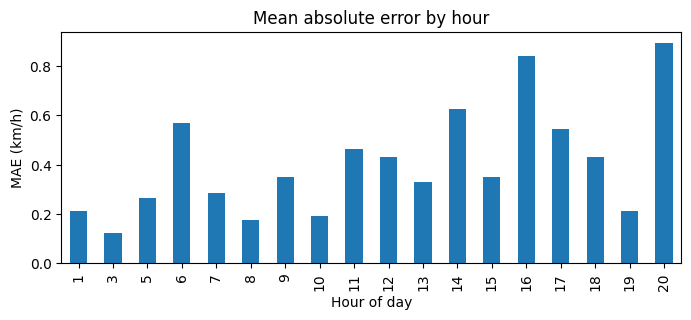

Using latest file for live test: ..\data\tomtom\eindhoven\eindhoven_20251207T233001Z.json
Live MAE: 0.27143681974214556
Live MAE: 0.27143681974214556


,target_speed,pred_speed,_ts,_plat,_plon
0,41.0,41.555673,2025-12-02 15:59:13+00:00,51.45996,5.52935
56,48.0,48.208713,2025-12-02 15:59:13+00:00,51.45618,5.51725
55,48.0,48.208713,2025-12-02 15:59:13+00:00,51.45627,5.51533
54,22.0,20.133064,2025-12-02 15:59:13+00:00,51.45628,5.51334
53,22.0,20.133064,2025-12-02 15:59:13+00:00,51.45608,5.51264


In [59]:
# Prepare dataset and train an improved model (LightGBM/XGBoost fallback, time-aware split, randomized CV)
df_feat = prepare_features(hist)
print('After feature prep:', len(df_feat))
# expand candidate features (lags and cyclical time)
base_feats = ['hour_sin','hour_cos','_dow','lag1','lag2','rolling_mean_3']
feat_cols = [c for c in base_feats if c in df_feat.columns]
X = df_feat[feat_cols].fillna(-1)
y = df_feat['target_speed']

# Basic data checks and defensive behavior
if df_feat.empty or len(X) == 0:
    print('Not enough data after feature engineering to train a model.')
else:
    # Time-based split: train on earlier data, test on the most recent 2 days if possible
    if '_ts' in df_feat.columns and df_feat['_ts'].notna().any():
        cutoff = df_feat['_ts'].max() - pd.Timedelta(days=2)
        train_idx = df_feat['_ts'] <= cutoff
        test_idx = df_feat['_ts'] > cutoff
        if train_idx.sum() < 100 or test_idx.sum() < 20:
            # fallback to a random split if not enough data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        else:
            X_train, X_test = X.loc[train_idx], X.loc[test_idx]
            y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print('Training rows:', len(X_train), 'Test rows:', len(X_test))

    # If training set is small, skip expensive CV/hyper-search and use a simple estimator
    MIN_SAMPLES_FOR_SEARCH = 50
    model = None
    if len(X_train) < MIN_SAMPLES_FOR_SEARCH:
        print(f'Only {len(X_train)} training rows (<{MIN_SAMPLES_FOR_SEARCH}). Skipping hyperparameter search and using RandomForest.')
        model = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)
    else:
        # Try LightGBM first (wrapped so any failure falls back cleanly)
        try:
            import lightgbm as lgb
            from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
            estimator = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=42)
            # choose cv splits conservatively based on data size
            n_splits = min(3, max(2, int(len(X_train) // 20)))
            cv = TimeSeriesSplit(n_splits=n_splits)
            param_dist = {
                'n_estimators': [100, 200, 400],
                'learning_rate': [0.01, 0.05, 0.1],
                'num_leaves': [31, 63, 127],
                'max_depth': [-1, 6, 12],
            }
            rsearch = RandomizedSearchCV(estimator, param_distributions=param_dist, n_iter=12, cv=cv, scoring='neg_mean_absolute_error', n_jobs=1, random_state=42, verbose=1)
            rsearch.fit(X_train, y_train)
            model = rsearch.best_estimator_
            print('Best params (LightGBM):', rsearch.best_params_)
        except Exception as e:
            print('LightGBM not available or failed, fallback to XGBoost/RandomForest:', e)
            try:
                import xgboost as xgb
                from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
                estimator = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=1, random_state=42)
                n_splits = min(3, max(2, int(len(X_train) // 20)))
                cv = TimeSeriesSplit(n_splits=n_splits)
                param_dist = {
                    'n_estimators': [100,200,400],
                    'learning_rate': [0.01,0.05,0.1],
                    'max_depth': [3,6,10],
                }
                rsearch = RandomizedSearchCV(estimator, param_distributions=param_dist, n_iter=12, cv=cv, scoring='neg_mean_absolute_error', n_jobs=1, random_state=42, verbose=1)
                rsearch.fit(X_train, y_train)
                model = rsearch.best_estimator_
                print('Best params (XGBoost):', rsearch.best_params_)
            except Exception as e2:
                print('XGBoost not available or failed, using RandomForest:', e2)
                model = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
                model.fit(X_train, y_train)

    # If we used a search object, ensure model is fitted (some branches already fitted)
    try:
        model.predict(X_test[:1])
    except Exception:
        model.fit(X_train, y_train)

    # Predictions and evaluation
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    mse_val = mean_squared_error(y_test, pred)
    rmse_val = np.sqrt(mse_val)
    print('MAE:', mae)
    print('RMSE:', rmse_val)

    # Feature importances if available
    try:
        importances = None
        if hasattr(model, 'feature_importances_'):
            importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        elif hasattr(model, 'booster') and hasattr(model, 'get_score'):
            # xgboost
            try:
                fmap = model.get_booster().get_score(importance_type='weight')
                importances = pd.Series(fmap).reindex(X_train.columns).fillna(0).sort_values(ascending=False)
            except Exception:
                importances = None
        if importances is not None:
            print('Feature importances:')
            print(importances)
    except Exception as e:
        print('Could not extract feature importances:', e)

    # Save model and feature list
    joblib.dump({'model': model, 'features': X_train.columns.tolist()}, f'model_{region}.joblib')
    print('Saved model to', f'model_{region}.joblib')

    # Diagnostic plots: predicted vs actual and error by hour
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,5))
        plt.scatter(y_test, pred, alpha=0.4)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Actual speed')
        plt.ylabel('Predicted speed')
        plt.title('Actual vs Predicted')
        plt.grid(True)
        plt.show()
        # error by hour
        res_df = pd.DataFrame({'actual': y_test, 'pred': pred})
        res_df['_ts'] = df_feat.loc[y_test.index, '_ts'] if '_ts' in df_feat.columns else pd.NaT
        if '_ts' in res_df and res_df['_ts'].notna().any():
            res_df['_hour'] = res_df['_ts'].dt.hour
            err_by_hour = (res_df['actual'] - res_df['pred']).abs().groupby(res_df['_hour']).mean()
            plt.figure(figsize=(8,3))
            err_by_hour.plot(kind='bar')
            plt.title('Mean absolute error by hour')
            plt.xlabel('Hour of day')
            plt.ylabel('MAE (km/h)')
            plt.show()
    except Exception as e:
        print('Plotting diagnostics failed:', e)


# Use latest live JSON in folder as test dataset (if available)
def load_latest_json_for_region(region: str, data_root: Path = Path('..') / 'data' / 'tomtom') -> Path:
    folder = data_root / region
    files = sorted(glob.glob(str(folder / '*.json')))
    if not files:
        return None
    return Path(files[-1])

latest = load_latest_json_for_region(region)
if latest is not None:
    print('Using latest file for live test:', latest)
    live_df = load_tomtom_jsons(region)  # load all then filter by newest timestamps if needed
    live_prep = prepare_features(live_df)
    X_live = live_prep[ [c for c in feat_cols if c in live_prep.columns] ].fillna(-1)
    preds = model.predict(X_live)
    live_prep['pred_speed'] = preds
    # evaluate where we have actuals
    if 'target_speed' in live_prep.columns:
        mae_live = mean_absolute_error(live_prep['target_speed'], live_prep['pred_speed'])
        print('Live MAE:', mae_live)
    display(live_prep[['target_speed','pred_speed','_ts','_plat','_plon']].head())


- This notebook is a starter template. Improvements: spatial joins to canonical road segments, using TomTom segment IDs, adding weather and event features, and training more advanced time-series models (LSTM, temporal convolutional nets).
- For production, collect stable segment identifiers (TomTom segment IDs) and build time-series per segment.
- Consider persistent caching for reverse-geocode and careful rate-limit handling when fetching live data.